In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
from datasets import Dataset

2024-06-04 07:51:48.639992: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 07:51:48.640050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 07:51:48.641449: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Load BERT model and tokenizer
model = TFAutoModel.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [4]:
# Function to tokenize data with reduced max_length
def tokenize(batch):
    return tokenizer(batch["text_combined"], padding='max_length', truncation=True, max_length=128)

english_speaking_countries = ['gb']
data_dir = "/kaggle/input/data-all"

def load_data(file_path):
    country_code = file_path.split('-')[1]  # Extract country code from filename
    try:
        df = pd.read_csv(file_path, delimiter='\t', quoting=3, on_bad_lines='skip')
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return pd.DataFrame()
    
    if country_code in english_speaking_countries:
        df['text_combined'] = df['text']
    else:
        df['text_combined'] = df['text_en']
    # Drop rows where 'text_combined' is NaN or empty
    df = df.dropna(subset=['text_combined'])
    df = df[df['text_combined'] != '']
    df['file_path'] = file_path  # Add file path information
    return df[['text_combined', 'label', 'file_path']]


# Function to split data within each country
def train_val_test_split_country(df, test_size=0.2, val_size=0.1):
    train_data, test_data = train_test_split(df, test_size=test_size, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=val_size/(1-test_size), random_state=42)
    return train_data, val_data, test_data


In [5]:
# Combine data from all files, splitting within each country first
train_dfs, val_dfs, test_dfs = [], [], []
for filename in os.listdir(data_dir):
    if filename.endswith(".tsv"):
        file_path = os.path.join(data_dir, filename)
        df = load_data(file_path)
        if not df.empty:
            train_df, val_df, test_df = train_val_test_split_country(df)
            train_dfs.append(train_df)
            val_dfs.append(val_df)
            test_dfs.append(test_df)

# Concatenate all country-specific splits
train_data = pd.concat(train_dfs, ignore_index=True)
val_data = pd.concat(val_dfs, ignore_index=True)
test_data = pd.concat(test_dfs, ignore_index=True)

In [6]:
# Create a Dataset object
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)

In [7]:
# Tokenize the datasets
train_encoded = train_dataset.map(tokenize, batched=True)
val_encoded = val_dataset.map(tokenize, batched=True)
test_encoded = test_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/98145 [00:00<?, ? examples/s]

Map:   0%|          | 0/14030 [00:00<?, ? examples/s]

Map:   0%|          | 0/28055 [00:00<?, ? examples/s]

In [8]:
# Set format for TensorFlow
train_encoded.set_format('tf', columns=['input_ids', 'attention_mask', 'token_type_ids', 'label'])
val_encoded.set_format('tf', columns=['input_ids', 'attention_mask', 'token_type_ids', 'label'])
test_encoded.set_format('tf', columns=['input_ids', 'attention_mask', 'token_type_ids', 'label'])


In [9]:
# Convert datasets to TensorFlow format
def to_tf_dataset(encoded_dataset, batch_size):
    def generator():
        for example in encoded_dataset:
            yield ({'input_ids': example['input_ids'],
                    'attention_mask': example['attention_mask'],
                    'token_type_ids': example['token_type_ids']}, example['label'])
    
    return tf.data.Dataset.from_generator(generator,
                                          output_signature=(
                                              {
                                                  'input_ids': tf.TensorSpec(shape=(128,), dtype=tf.int32),
                                                  'attention_mask': tf.TensorSpec(shape=(128,), dtype=tf.int32),
                                                  'token_type_ids': tf.TensorSpec(shape=(128,), dtype=tf.int32)
                                              },
                                              tf.TensorSpec(shape=(), dtype=tf.int64)
                                          )).batch(batch_size)

BATCH_SIZE = 64 

# Convert datasets to TensorFlow format
train_dataset = to_tf_dataset(train_encoded, BATCH_SIZE).shuffle(1000)
val_dataset = to_tf_dataset(val_encoded, BATCH_SIZE)
test_dataset = to_tf_dataset(test_encoded, BATCH_SIZE)

In [10]:
# Define the classification model
class BERTForClassification(tf.keras.Model):
    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert = bert_model
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')
        
    def call(self, inputs):
        x = self.bert(inputs)[1]
        return self.fc(x)


In [11]:
classifier = BERTForClassification(model, num_classes=2)

# Note: Use a mixed precision optimizer for better performance
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

classifier.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)


In [12]:
history = classifier.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=4,
    verbose=1  # Add verbosity to see training progress
)

Epoch 1/4


I0000 00:00:1717487872.786757    3841 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1534/1534 [==============================] - 1701s 981ms/step - loss: 0.6134 - accuracy: 0.6487 - val_loss: 0.5692 - val_accuracy: 0.6888
Epoch 2/4
1534/1534 [==============================] - 1605s 973ms/step - loss: 0.5460 - accuracy: 0.7103 - val_loss: 0.5554 - val_accuracy: 0.6908
Epoch 3/4
1534/1534 [==============================] - 1601s 971ms/step - loss: 0.4858 - accuracy: 0.7527 - val_loss: 0.5440 - val_accuracy: 0.7152
Epoch 4/4
1534/1534 [==============================] - 1602s 972ms/step - loss: 0.4180 - accuracy: 0.7978 - val_loss: 0.5611 - val_accuracy: 0.7249


In [13]:
classifier.evaluate(test_dataset)

439/439 [==============================] - 170s 386ms/step - loss: 0.5668 - accuracy: 0.7206


[0.5668364763259888, 0.7205845713615417]

In [14]:
# Save the trained BERT model and tokenizer
model_save_path = "/kaggle/working/saved_model"
tokenizer_save_path = "/kaggle/working/saved_tokenizer"
classifier_save_path = "/kaggle/working/saved_classifier"

In [15]:
# Save the BERT model inside the classifier
classifier.bert.save_pretrained(model_save_path)

# Save the tokenizer
tokenizer.save_pretrained(tokenizer_save_path)

# Save the entire classifier model
classifier.save(classifier_save_path)

In [ ]:
# Load the tokenizer
#tokenizer = AutoTokenizer.from_pretrained(tokenizer_save_path)

# Load the BERT model
#bert_model = TFAutoModel.from_pretrained(model_save_path)

# Instantiate the classifier with the loaded BERT model
#classifier = BERTForClassification(bert_model, num_classes=2)

# Compile the classifier (necessary before using it)
#classifier.compile(
#    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
#    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#    metrics=['accuracy']
#)

In [16]:
import re

def extract_country_code(file_path):
    match = re.search(r'orientation-([a-z]{2}(?:-[a-z]{2})?)-train.tsv', file_path)
    if match:
        return match.group(1)
    print("No match found from: {file_path}")
    return None

# Add country code to the data
test_data['country_code'] = test_data['file_path'].apply(extract_country_code)

In [17]:
# Function to get predictions (ne koristim)
def get_predictions(dataset):
    predictions = []
    labels = []
    for batch in dataset:
        inputs, label = batch
        inputs = {key: tf.convert_to_tensor(val) for key, val in inputs.items()}
        logits = classifier(inputs, training=False)
        predictions.extend(logits.numpy())
        # predictions.extend(tf.nn.softmax(logits).numpy())
        labels.extend(label.numpy())
    return np.array(predictions), np.array(labels)

In [19]:
import numpy as np

In [ ]:
# Get predictions for test data (ne)
predictions, labels = get_predictions(test_dataset)

In [20]:
labels = []
for batch in test_dataset:
    inputs, label = batch
    labels.extend(label.numpy())
labels = np.array(labels)

In [21]:
predictions = classifier.predict(test_dataset)


439/439 [==============================] - 179s 386ms/step


In [23]:
predictions

array([[0.19082616, 0.8091738 ],
       [0.6520297 , 0.3479703 ],
       [0.04097091, 0.9590291 ],
       ...,
       [0.56715745, 0.43284252],
       [0.35139558, 0.64860445],
       [0.47302273, 0.52697724]], dtype=float32)

In [30]:
def calculate_mean_probabilities(data, predictions, labels):
    country_means = {}
    for country in data['country_code'].unique():
        print(f"Processing country: {country}")
        country_indices = data['country_code'] == country
        country_labels = labels[country_indices]
        country_predictions = predictions[country_indices]
        if country_labels.size > 0:  
            right_mean = np.mean(country_predictions[country_labels == 1][:, 1])
            left_mean = np.mean(country_predictions[country_labels == 0][:, 0])
            country_means[country] = (right_mean, left_mean)
            print(f"Country: {country}, Right Mean: {right_mean}, Left Mean: {left_mean}")
        else:
            print(f"No data for country: {country}")
    return country_means



In [31]:
# Calculate mean probabilities for each country
country_means = calculate_mean_probabilities(test_data, predictions, labels)

# Check the resulting country means
print(f"Country Means: {country_means}")

Processing country: gr
Country: gr, Right Mean: 0.6246136426925659, Left Mean: 0.4744565486907959
Processing country: es
Country: es, Right Mean: 0.6830650568008423, Left Mean: 0.5892194509506226
Processing country: fr
Country: fr, Right Mean: 0.7182421684265137, Left Mean: 0.40848493576049805
Processing country: no
Country: no, Right Mean: 0.555167555809021, Left Mean: 0.6017467975616455
Processing country: dk
Country: dk, Right Mean: 0.5594102144241333, Left Mean: 0.6494012475013733
Processing country: is
Country: is, Right Mean: 0.6355341076850891, Left Mean: 0.4689466655254364
Processing country: tr
Country: tr, Right Mean: 0.8056628108024597, Left Mean: 0.7283297181129456
Processing country: lv
Country: lv, Right Mean: 0.8569368720054626, Left Mean: 0.36756041646003723
Processing country: si
Country: si, Right Mean: 0.3485317528247833, Left Mean: 0.7035935521125793
Processing country: cz
Country: cz, Right Mean: 0.6614951491355896, Left Mean: 0.4519161880016327
Processing country:

In [32]:
from matplotlib import pyplot as plt
%matplotlib inline

In [39]:
# Plot the results
countries = list(country_means.keys())
right_means = [country_means[c][0] for c in countries]
left_means = [country_means[c][1] for c in countries]


Text(0.5, 1.0, 'Right-Wing Mean Probabilities by Country')

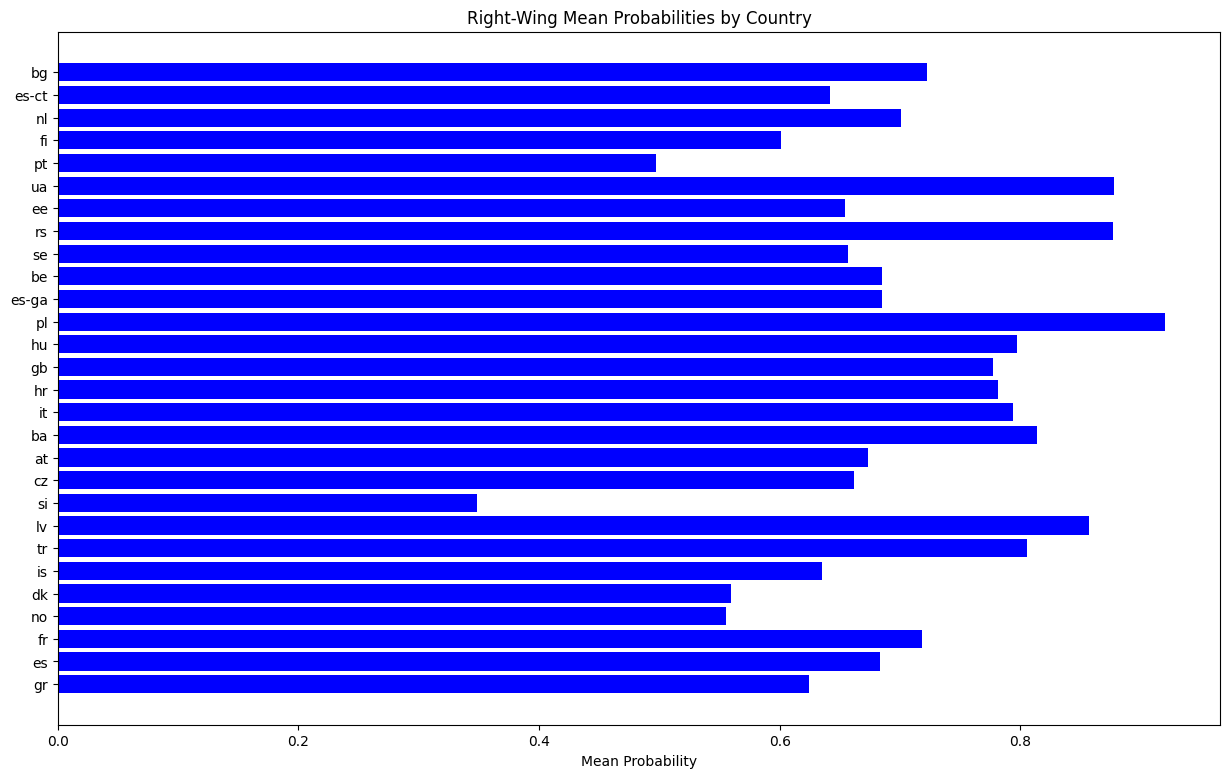

In [41]:
# Plot right-wing mean probabilities
plt.figure(figsize=(15, 9))
plt.barh(countries, right_means, color='blue')
plt.xlabel('Mean Probability')
plt.title('Right-Wing Mean Probabilities by Country')

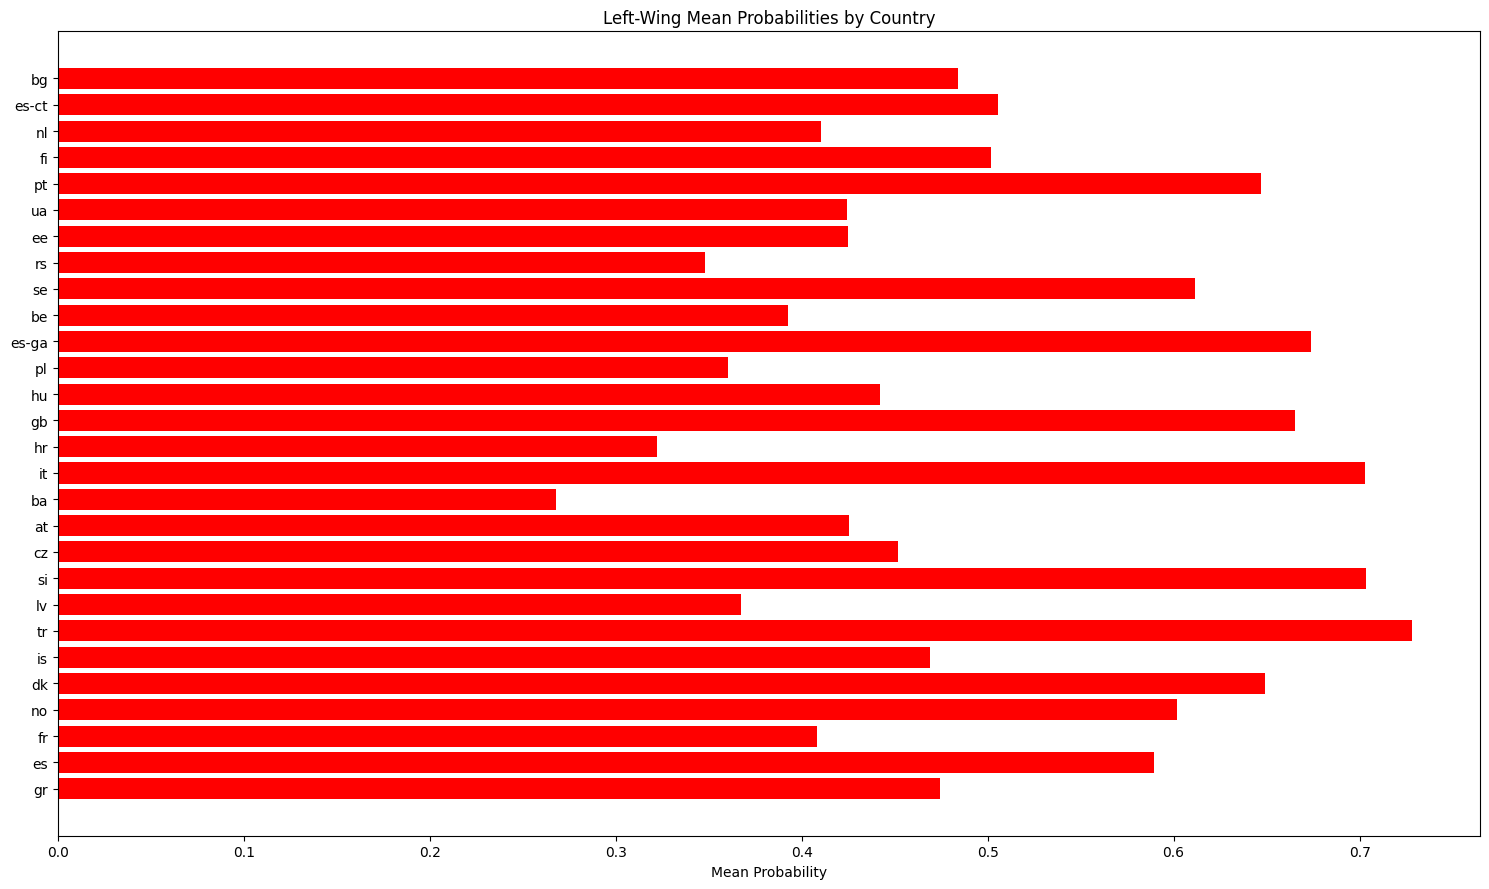

In [42]:
# Plot left-wing mean probabilities
plt.figure(figsize=(15, 9))
plt.barh(countries, left_means, color='red')
plt.xlabel('Mean Probability')
plt.title('Left-Wing Mean Probabilities by Country')

plt.tight_layout()
plt.show()